In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import ipyplot
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from collections import defaultdict
import os

In [3]:
from tensorflow_similarity.samplers import SingleShotMemorySampler

# dataset

## loading

In [4]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
print("x_train", x_train.shape, "x_test", x_test.shape)
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)
print("y_train", y_train.shape, "y_test", y_test.shape)

x_train (50000, 32, 32, 3) x_test (10000, 32, 32, 3)
y_train (50000, 10) y_test (10000, 10)


In [5]:
IMG_SIZE = 32

In [6]:
from tensorflow_similarity.samplers import RandAugment
# FIXME: refactor augmenter as an object 
# FIXME: support swav multi views that return [x1, x2, x3 ...xn]
# and allows to pass multiple size
# FIXME extend image augmentation to have an PolicyAug that accept a 
# policy as input and execut it so its easier to do both

# pass as a class
CPU_COUNT = os.cpu_count()

@tf.function()
def process(img):
    augmenter = RandAugment() 
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    #img = tf.image.random_crop(img, (IMG_SIZE, IMG_SIZE, 3))
    img = augmenter.distort(img)
    return img

@tf.function()
def augmenter(x, y, num_views, is_warmup):
    """Creates two views of the images and return them as X and Y
     

    Args:
        x: raw images
        y: unused 
        num_augmentations_per_examples: [description]
        is_warmup ([type]): [description]
    """
    IMG_MAX_SIZE = int(IMG_SIZE * 1.5) # allow ot pass in the init
    
    augmenters = []
    for v in range(num_views):
        # FIXME deal with different policy per view
        augmenters.append(RandAugment())

    with tf.device("/cpu:0"):
        imgs = tf.stack(x)
        imgs = tf.cast(imgs, dtype='float32')
        batch = []
        for v in range(num_views):
            view = tf.map_fn(process, imgs, parallel_iterations=CPU_COUNT)
            batch.append(view)
        return batch


In [7]:
sampler = SingleShotMemorySampler(x_train, examples_per_batch=32, augmenter=augmenter, num_augmentations_per_example=2)


The initial batch size is 96 (32 classes * 1 examples per class) with 2 augmenters



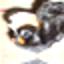
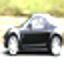
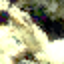
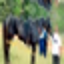
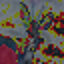
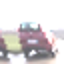
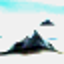
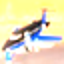
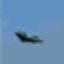
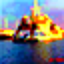


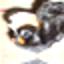
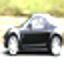
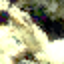
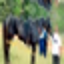
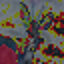
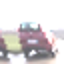
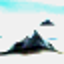
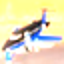
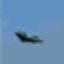
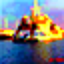

In [8]:
batch = sampler.generate_batch(0)
ipyplot.plot_images(batch[1], img_width=64, max_images=10)

# Models

## backbone 

In [9]:
def get_encoder(IMG_SIZE):
	base_model = tf.keras.applications.ResNet50V2(include_top=False,
		weights=None, input_shape=(IMG_SIZE, IMG_SIZE, 3))
	base_model.trainable = True

	inputs = layers.Input((IMG_SIZE, IMG_SIZE, 3))
	# no rescaling as efficientnet do it for you
	x = base_model(inputs, training=True)
 
 	# < this is the representation
	o = layers.GlobalAveragePooling2D()(x) 
	backbone = Model(inputs, o, name='encoder')
	return backbone
encoder = get_encoder(IMG_SIZE)
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
resnet50v2 (Functional)      (None, 1, 1, 2048)        23564800  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
Total params: 23,564,800
Trainable params: 23,519,360
Non-trainable params: 45,440
_________________________________________________________________


## projector model

In [10]:
def get_projector(dim, activation='relu'):
    inputs = layers.Input(shape=(dim,))
    x = layers.Dense(dim, activation=activation)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(dim, activation=activation)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(dim)(x)
    x = layers.BatchNormalization()(x)
    projector = Model(inputs, x, name="projector")
    return projector

projector = get_projector(2048)
projector.summary()

Model: "projector"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 2048)]            0         
_________________________________________________________________
dense (Dense)                (None, 2048)              4196352   
_________________________________________________________________
batch_normalization (BatchNo (None, 2048)              8192      
_________________________________________________________________
dense_1 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
batch_normalization_1 (Batch (None, 2048)              8192      
_________________________________________________________________
dense_2 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
batch_normalization_2 (Batch (None, 2048)              81

# Loss

In [11]:
@tf.function
def SiamSiamLoss(z, p):
    # The authors of SimSiam emphasize the impact of
    # the `stop_gradient` operator in the paper as it
    # has an important role in the overall optimization.
    z = tf.stop_gradient(z)
    p = tf.math.l2_normalize(p, axis=1)
    z = tf.math.l2_normalize(z, axis=1)
    # Note we do cosine similarity not negative cosine similarity
    # as in the paper to get the loss to be between [4, 0]
    vals = -p * z
    vals = tf.reduce_sum(vals, axis=1)
    return tf.reduce_mean(vals, axis=0)

In [12]:
class ContrastiveModel(tf.keras.Model):
    
    def __init__(self, encoder_model, projector_model, swap_representation=False) -> None:
        super(ContrastiveModel, self).__init__()
        
        self.encoder = encoder_model
        self.projector = projector_model
        self.swap_representation = swap_representation
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")
    
    @tf.function
    def train_step(self, data):
        view1, view2 = data
        
        # Forward pass through the encoder and predictor
        with tf.GradientTape() as tape:
            
            # compute representation
            z1 = self.encoder(view1)
            z2 = self.encoder(view2)
            
            # compute projection
            p1 = self.projector(z1)
            p2 = self.projector(z2)
            
            # Allows to swap projections (ala SiamSiam)
            if self.swap_representation:
                l1_args = (z1, p2)
                l2_args = (z2, p1)
            else:
                l1_args = (z1, p1)
                l2_args = (z2, p2)
                
            l1 = self.compiled_loss(*l1_args)
            l2 = self.compiled_loss(*l2_args)
            # +1 ensure the minimal loss is 0 as usual
            loss = (l1 + l2) + 2

        # collect train variables from both the encoder and the projector
        tvars = self.encoder.trainable_variables + self.projector.trainable_variables
        
        # Compute gradients
        gradients = tape.gradient(loss, tvars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, tvars))
        
        # Update metrics
        # !This are contrastive metrics with different input
        # TODO: figure out interesting metrics -- z Mae?
        # TODO: check metrics are of the right type in compile?
        self.compiled_metrics.update_state([z1, z2], [p1, p2])
        
        # report loss manually
        self.loss_tracker.update_state(loss)
        
        # Return a dict mapping metric names to current value
        return {m.name: m.result() for m in self.metrics}
    
    
    # fix TF 2.x < 2.7 bugs when using generator
    def call(self, inputs):
        return inputs
        
    
    def get_encoder(self):
        "Return encoder model"
        return self.encoder
    
    # fixme custom summary()

In [13]:
@tf.function
def encstdev(zs, ps):
    """Measure the representation embedding standard deviation

    Used to measure if the embeddings are collapsing: if equal
    to zero the model learned a degenerated solution.
    
    Introduced in: Exploring Simple Siamese Representation Learning
    https://openaccess.thecvf.com/content/CVPR2021/papers/Chen_Exploring_Simple_Siamese_Representation_Learning_CVPR_2021_paper.pdf
     
    """
    # only measure stddev on one z as its shared weights.
    stddev = tf.math.reduce_std(tf.math.l2_normalize(zs[0]))
    #FIXME: Owen to fix his complicated super duper estiamte
    # #z_shape = tf.shape(zs[0][0])[0]
    # metric = (1/tf.sqrt(2048.0) - stddev)
    return stddev

In [14]:
PRE_TRAIN_EPOCHS = 20
# FIXME rename as contrastive model
model = ContrastiveModel(encoder_model=encoder, 
                         projector_model=projector, 
                         swap_representation=True)
# sgd as optimizer
model.compile('sgd', loss=SiamSiamLoss, metrics=[encstdev])
history = model.fit(sampler, epochs=PRE_TRAIN_EPOCHS, steps_per_epoch=1000)

Epoch 1/20
1000/1000 [==============================] - 72s 62ms/step - loss: 0.9648 - output_1_encstdev: 0.0182 - output_2_encstdev: 0.0182
Warmup complete
Epoch 2/20
1000/1000 [==============================] - 71s 70ms/step - loss: 0.8679 - output_1_encstdev: 0.0182 - output_2_encstdev: 0.0182
Epoch 3/20
1000/1000 [==============================] - 61s 61ms/step - loss: 0.8609 - output_1_encstdev: 0.0182 - output_2_encstdev: 0.0182
Epoch 4/20
1000/1000 [==============================] - 62s 62ms/step - loss: 0.8569 - output_1_encstdev: 0.0182 - output_2_encstdev: 0.0182
Epoch 5/20
1000/1000 [==============================] - 63s 62ms/step - loss: 0.8537 - output_1_encstdev: 0.0182 - output_2_encstdev: 0.0182
Epoch 6/20
1000/1000 [==============================] - 63s 63ms/step - loss: 0.8509 - output_1_encstdev: 0.0182 - output_2_encstdev: 0.0181
Epoch 7/20
1000/1000 [==============================] - 61s 61ms/step - loss: 0.8498 - output_1_encstdev: 0.0181 - output_2_encstdev: 0.01

In [15]:
TEST_EPOCHS = 5

# No pretrain

In [16]:
# rename as reg
no_encoder = get_encoder(IMG_SIZE)

inputs = layers.Input((IMG_SIZE, IMG_SIZE, 3))
# no rescaling as efficientnet do it for you
x = no_encoder(inputs, training=True)
o = layers.Dense(10, activation='softmax')(x)
reg_model = Model(inputs, o, name='no_pretrain')

reg_model.compile('adam', loss='categorical_crossentropy', metrics=['acc'])
reg_model.fit(x_train, y_train, epochs=TEST_EPOCHS, validation_data=(x_test, y_test))

Epoch 1/5
1563/1563 [==============================] - 50s 29ms/step - loss: 1.9001 - acc: 0.3484 - val_loss: 1.6643 - val_acc: 0.4250
Epoch 2/5
1563/1563 [==============================] - 44s 28ms/step - loss: 1.7724 - acc: 0.3903 - val_loss: 1.6256 - val_acc: 0.4043
Epoch 3/5
1563/1563 [==============================] - 45s 29ms/step - loss: 1.7000 - acc: 0.4044 - val_loss: 1.7110 - val_acc: 0.3877
Epoch 4/5
1563/1563 [==============================] - 45s 29ms/step - loss: 1.5574 - acc: 0.4443 - val_loss: 1.3996 - val_acc: 0.5001
Epoch 5/5
1563/1563 [==============================] - 44s 28ms/step - loss: 1.3978 - acc: 0.5065 - val_loss: 1.4050 - val_acc: 0.5130


In [17]:
# pretrained with SiamSiam

In [18]:
encoder = model.get_encoder()

inputs = layers.Input((IMG_SIZE, IMG_SIZE, 3))
# no rescaling as efficientnet do it for you
x = encoder(inputs, training=True)
o = layers.Dense(10, activation='softmax')(x)
pre_model = Model(inputs, o, name='pretrained')

pre_model.compile('adam', loss='categorical_crossentropy', metrics=['acc'])
pre_model.fit(x_train, y_train, epochs=TEST_EPOCHS, validation_data=(x_test, y_test))

Epoch 1/5
1563/1563 [==============================] - 50s 30ms/step - loss: 1.9209 - acc: 0.3382 - val_loss: 1.7622 - val_acc: 0.3908
Epoch 2/5
1563/1563 [==============================] - 46s 29ms/step - loss: 1.7454 - acc: 0.4017 - val_loss: 1.7707 - val_acc: 0.3916
Epoch 3/5
1563/1563 [==============================] - 46s 29ms/step - loss: 1.5829 - acc: 0.4561 - val_loss: 1.4241 - val_acc: 0.4964
Epoch 4/5
1563/1563 [==============================] - 46s 29ms/step - loss: 1.3754 - acc: 0.5235 - val_loss: 1.2708 - val_acc: 0.5583
Epoch 5/5
1563/1563 [==============================] - 46s 29ms/step - loss: 1.2153 - acc: 0.5794 - val_loss: 1.1302 - val_acc: 0.6013
